In [1]:
import requests
import apimoex
import ts2vg as ts
from igraph import *
import numpy as np
import networkx as nx
import igraph as ig
import cairocffi
import matplotlib.pyplot as plt
import pandas as pd

In [186]:
import random
random.seed(0)

#### TASK 1

<Axes: >

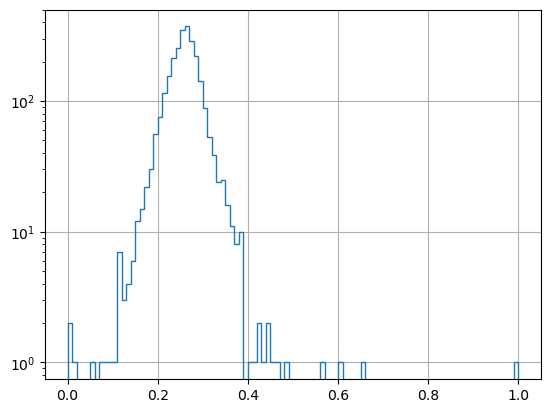

In [770]:
# download MOEX data , calculate normilized returns
# display it into visibility graph: regular and horizontal
# plot and compare

with requests.Session() as session:
    data = apimoex.get_board_history(session, 'SBER')
    df = pd.DataFrame(data).drop(columns=['VALUE', 'BOARDID'])
    df.set_index('TRADEDATE', inplace=True)
    df.index = pd.to_datetime(df.index)
    df = df[pd.to_datetime('2010-01-01'):]
    
df['log_return'] = df['CLOSE'].pct_change()
df = df.dropna()
df['norm_return'] = (df['log_return'].max() - df['log_return']) / (df['log_return'].max() - df['log_return'].min())
df['norm_return'].hist(histtype='step', bins=100, log=True)

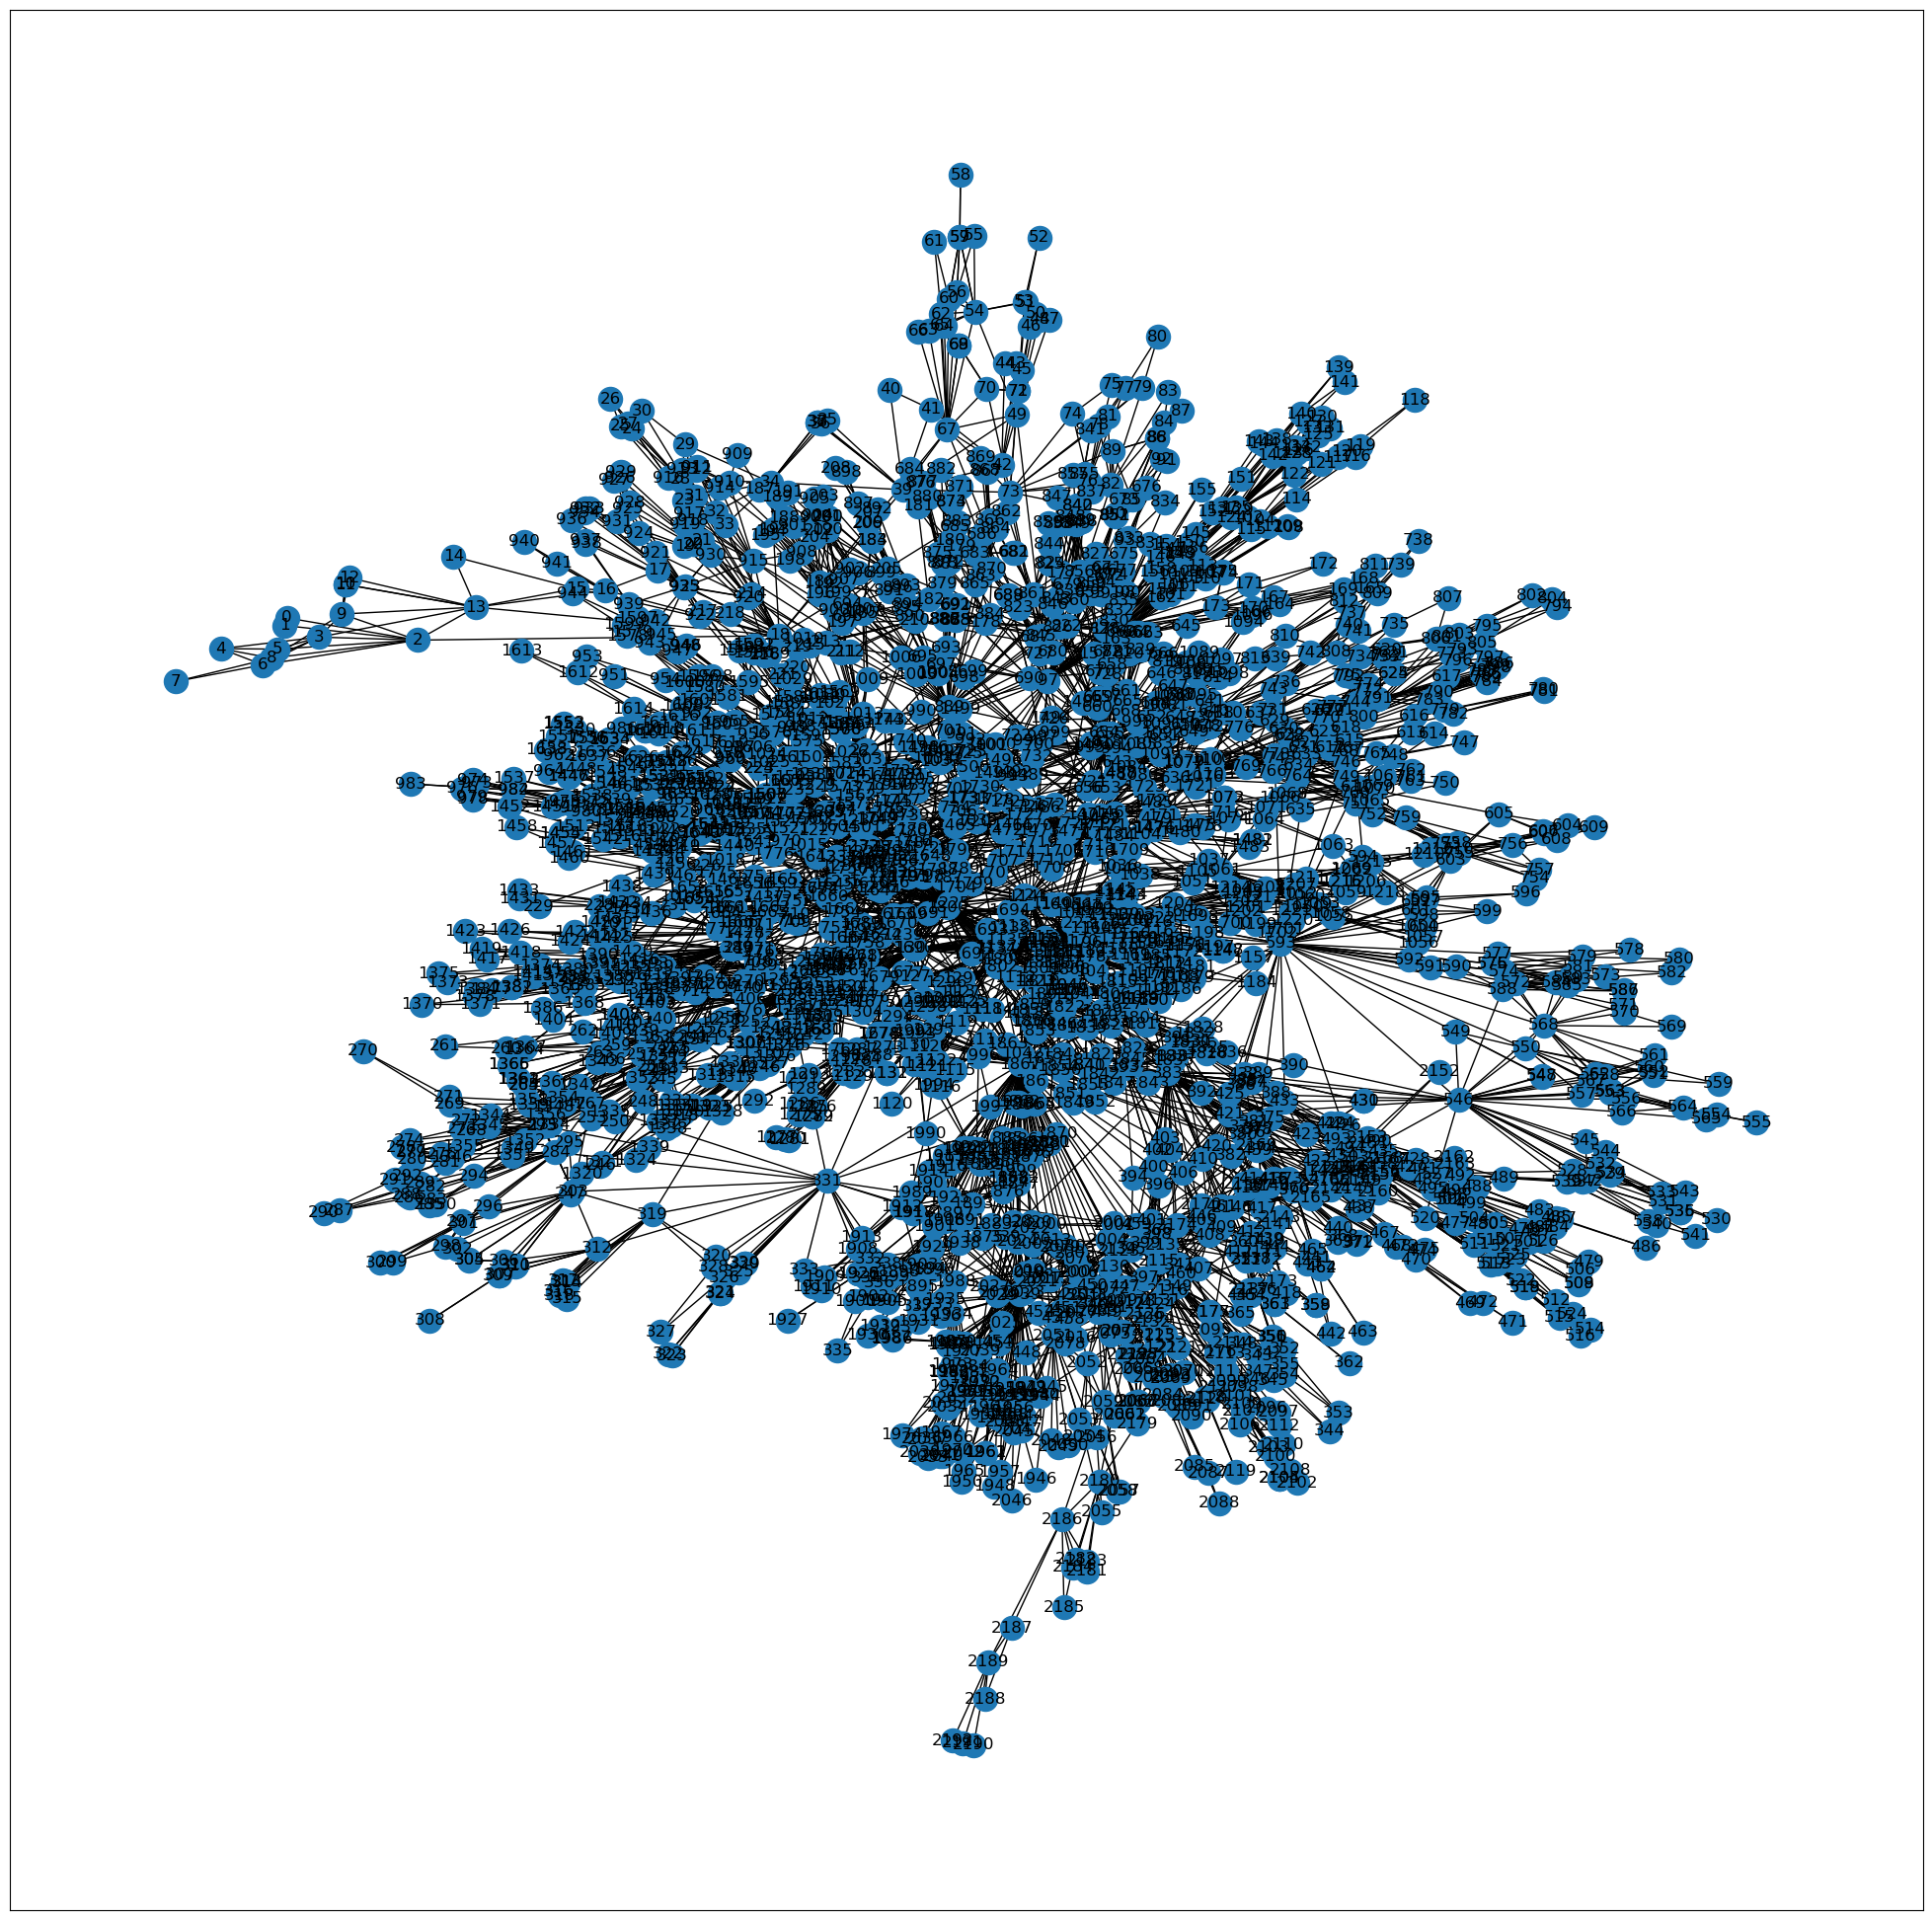

<Figure size 200x200 with 0 Axes>

In [727]:
vg = ts.NaturalVG()
vg.build(df['norm_return'])

ivg = vg.as_igraph()
nxvg = vg.as_networkx()

# plt.figure(figsize =(25, 25))
# nx.draw_networkx(nxvg, with_labels = True)

plot the graph
plt.figure(figsize=(2, 2))
ig.plot(ivg,
        vertex_size=5,
        #vertex_label=g.vs['names'],
        #edge_label=g.es['weight'],
        bbox=(400, 400)
        )

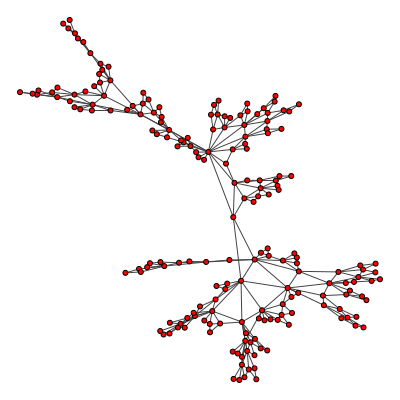

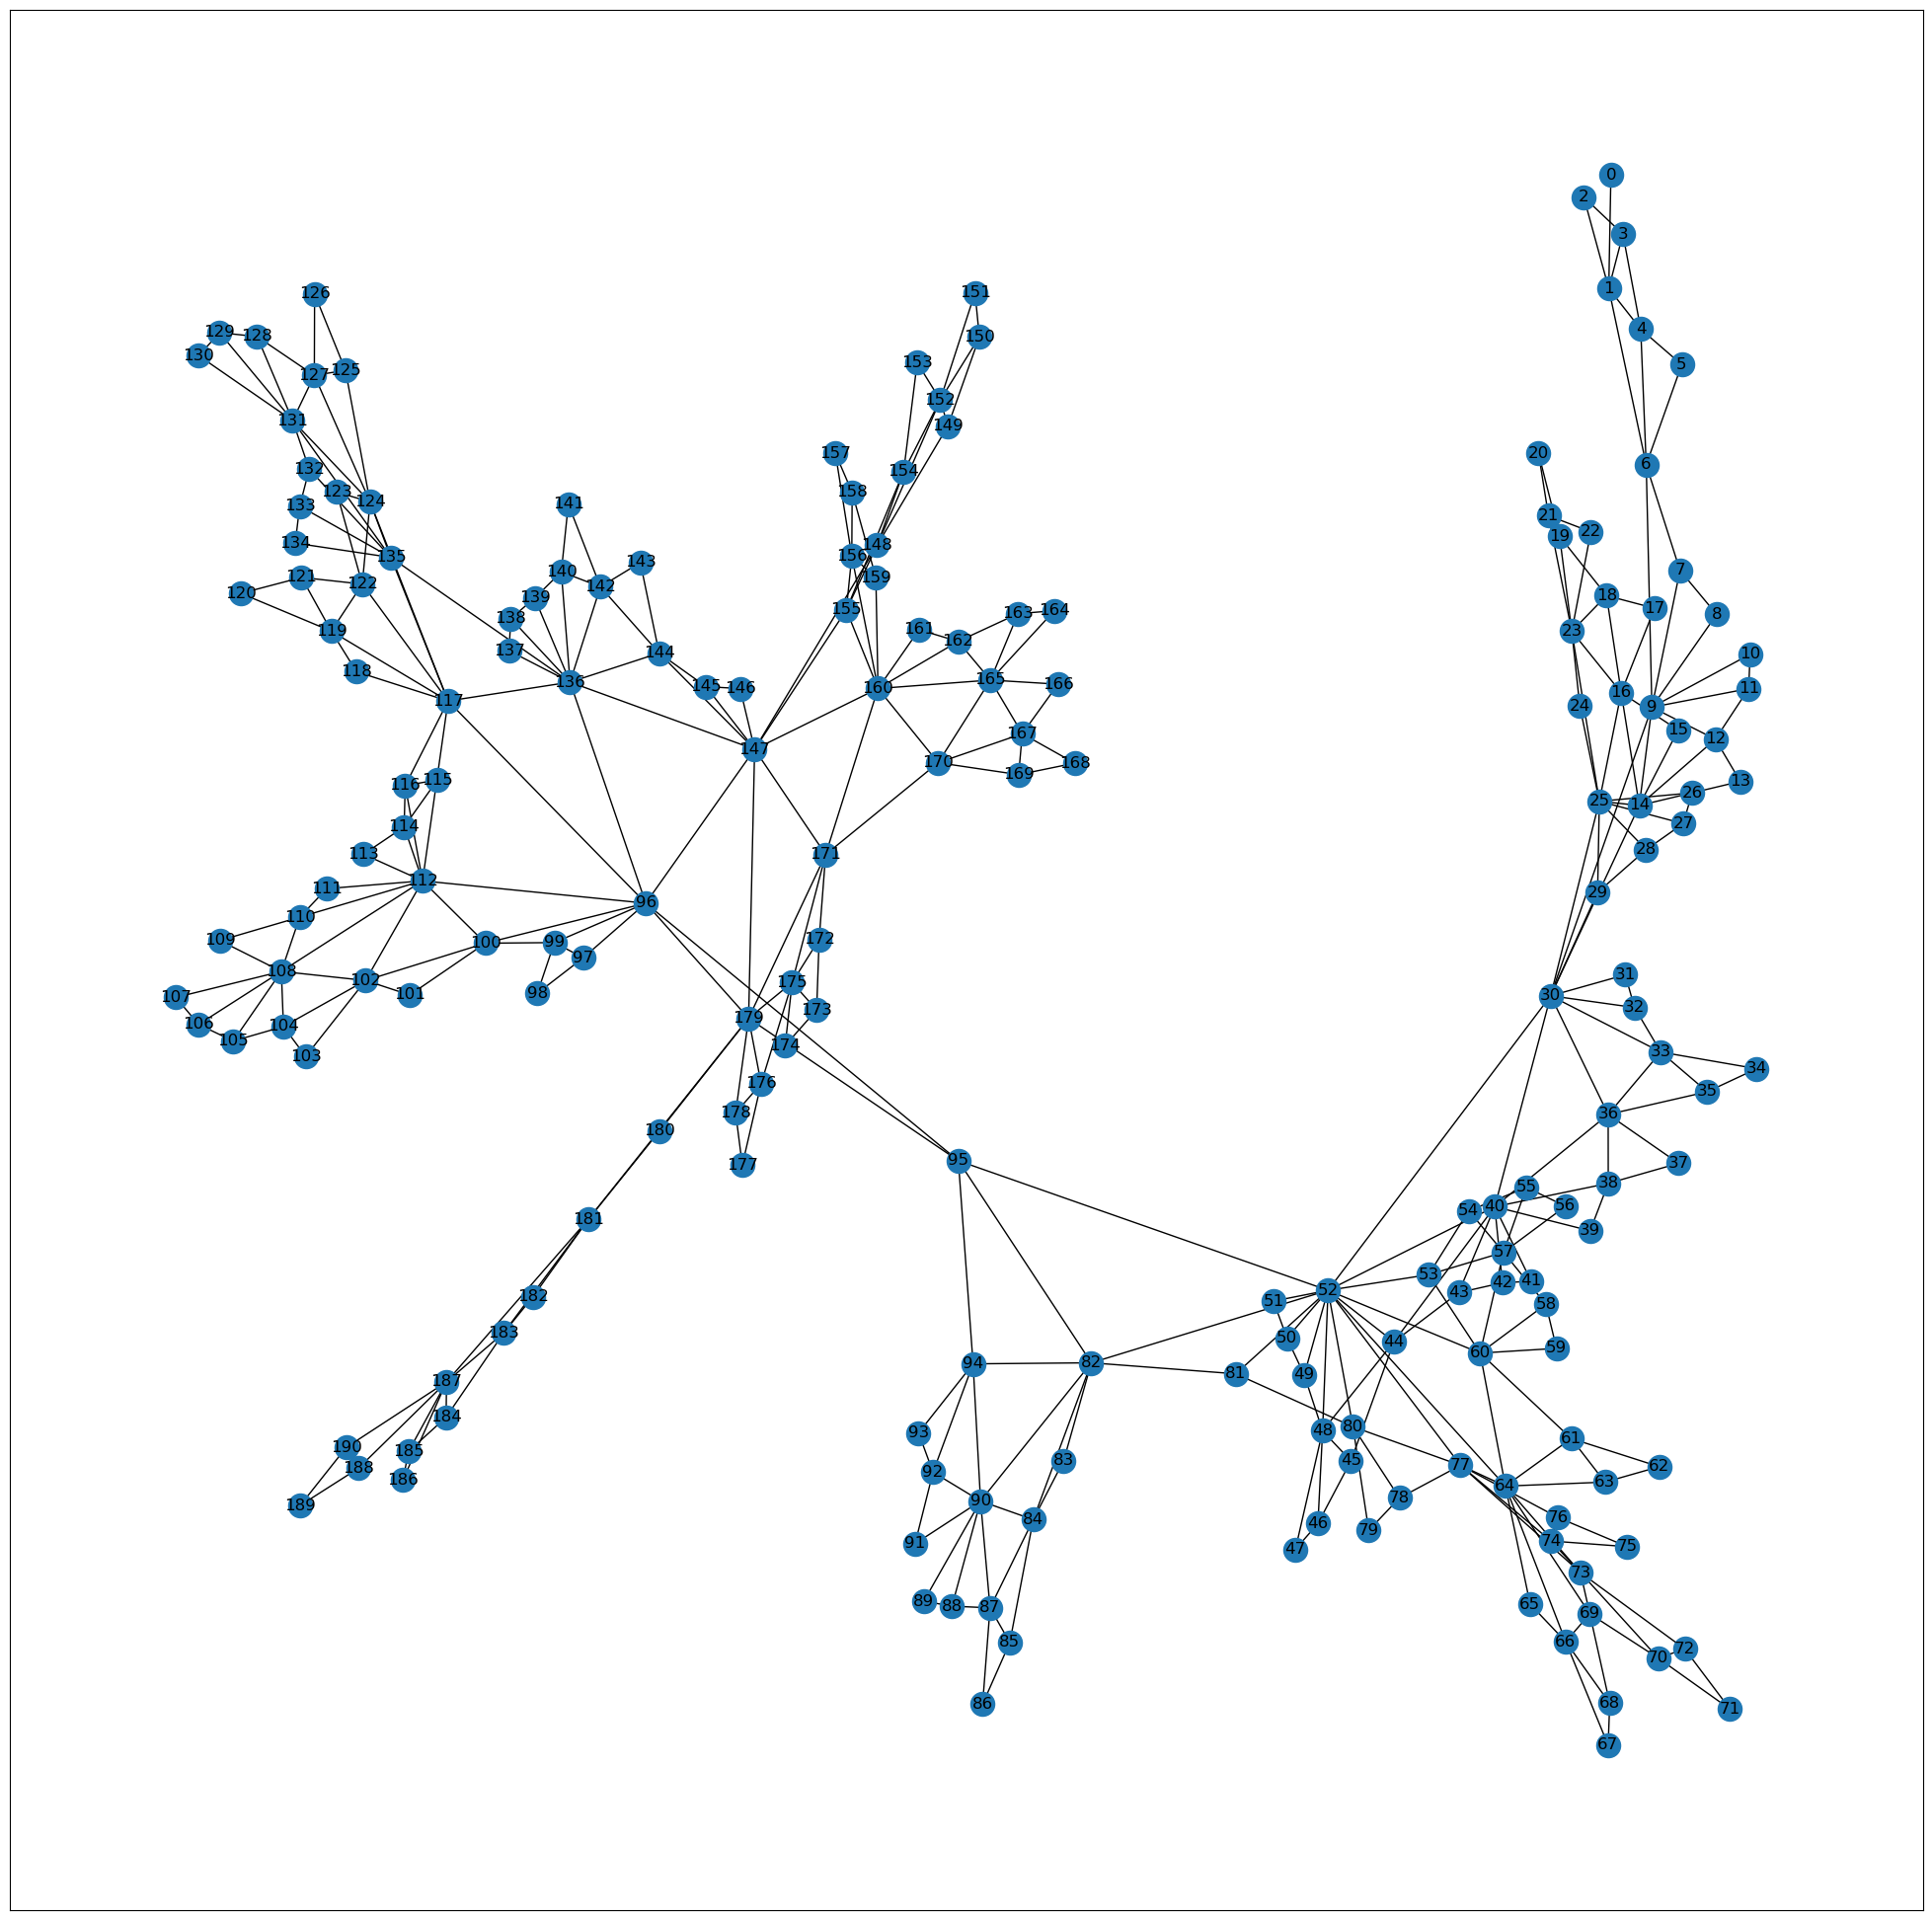

<Figure size 200x200 with 0 Axes>

In [4]:
vg = ts.HorizontalVG()
vg.build(df['norm_return'])

ihg = vg.as_igraph()
nxhg = vg.as_networkx()

plt.figure(figsize =(25, 25))
nx.draw_networkx(nxhg, with_labels = True)

# plot the graph
plt.figure(figsize=(2, 2))
ig.plot(ihg,
        vertex_size=5,
        #vertex_label=g.vs['names'],
        #edge_label=g.es['weight'],
        bbox=(400, 400)
        )

In [208]:
from scipy import sparse

In [320]:
# compare two ways constructed graphs
print(f'Compare according adjacency matrices : {list(nxhg.adjacency()) == list(nxvg.adjacency())}')
print(f'Compare according adjacency matrices : { np.isclose(np.array(list(ihg.get_adjacency())), np.array(sparse.lil_matrix(nx.adjacency_matrix(nxhg)).toarray())).all()}')

Compare according adjacency matrices : False
Compare according adjacency matrices : True


#### TASK 2

In [554]:
tickers = ['GAZP', 'SBER', 'LKOH', 'YNDX', 'GMKN', 'NVTK', 'ROSN']
data_dict = {}
with requests.Session() as session:
    for ticker in tickers:
        data_dict[ticker] = pd.DataFrame(apimoex.get_board_history(session, ticker)).set_index('TRADEDATE')
        data_dict[ticker].index = pd.to_datetime(data_dict[ticker].index)
        data_dict[ticker] = data_dict[ticker]['CLOSE']

In [555]:
start_date = pd.to_datetime('2023-01-01')

tickers_df = pd.DataFrame(data_dict).dropna()[start_date:]

for ticker in tickers:
    tickers_df[f'{ticker}_norm_return'] = tickers_df[ticker].pct_change()
    tickers_df = tickers_df.dropna()
    tickers_df[f'{ticker}_norm_return'] = (tickers_df[f'{ticker}_norm_return'].max() - tickers_df[f'{ticker}_norm_return']) / (tickers_df[f'{ticker}_norm_return'].max() - tickers_df[f'{ticker}_norm_return'].min())
    tickers_df[f'{ticker}_norm_return'] = 2 * tickers_df[f'{ticker}_norm_return'] - 1

In [556]:
for ticker in tickers:
    tickers_df[f'mc_{ticker}'] = 'e'
    mask_R = tickers_df[f'{ticker}_norm_return'] > 0.15
    mask_r = tickers_df[f'{ticker}_norm_return'] > 0.05
    mask_d = tickers_df[f'{ticker}_norm_return'] < -0.05
    mask_D = tickers_df[f'{ticker}_norm_return'] < -0.15
    
    tickers_df.loc[(tickers_df[mask_r]).index, f'mc_{ticker}'] = 'r'
    tickers_df.loc[(tickers_df[mask_R]).index, f'mc_{ticker}'] = 'R'
    tickers_df.loc[(tickers_df[mask_D]).index, f'mc_{ticker}'] = 'D'
    tickers_df.loc[(tickers_df[mask_d]).index, f'mc_{ticker}'] = 'd'

In [435]:
mc_tickers = [f'mc_{ticker}' for ticker in tickers]
for date in tickers_df.index:
    tickers_df['market_condition'] = ''
    for ticker in mc_tickers:
        tickers_df['market_condition'] += tickers_df[ticker]

In [436]:
tickers_df['mc_transition'] = tickers_df['market_condition'] + tickers_df.shift(-1)['market_condition']
tickers_df = tickers_df.dropna()

In [486]:
transitions_dict = {}
for condition in tickers_df.market_condition.unique():
    transitions_dict[condition] = {}
    condition_state_num = tickers_df[tickers_df['market_condition'] == condition].count()[0]
    for condition2 in tickers_df.market_condition.unique():
        cond2cond_num = tickers_df[tickers_df['mc_transition'] == (condition + condition2)].count()[0]
        transitions_dict[condition][condition2] = round(cond2cond_num / condition_state_num, 3)
        
transitions_dict_df = pd.DataFrame(transitions_dict)

In [489]:
adjacency_matrix = np.zeros(shape=(len(transitions_dict), len(transitions_dict)), dtype=float)

for i, (condition1, transitions) in enumerate(transitions_dict.items()):
    for j, (condition2, transition_prob) in enumerate(transitions.items()):
        #print(condition1, i, condition2, j, transition_prob)
        adjacency_matrix[i, j] = transition_prob
        
#g = ig.Graph.Adjacency((adjacency_matrix > 0).tolist())
g = ig.Graph.Adjacency((adjacency_matrix > 0).tolist())
g.vs['names'] = [key for key in transitions_dict.keys()]
g.es['weight'] = adjacency_matrix[adjacency_matrix.nonzero()]

G = nx.DiGraph(transitions_dict_df > 0)

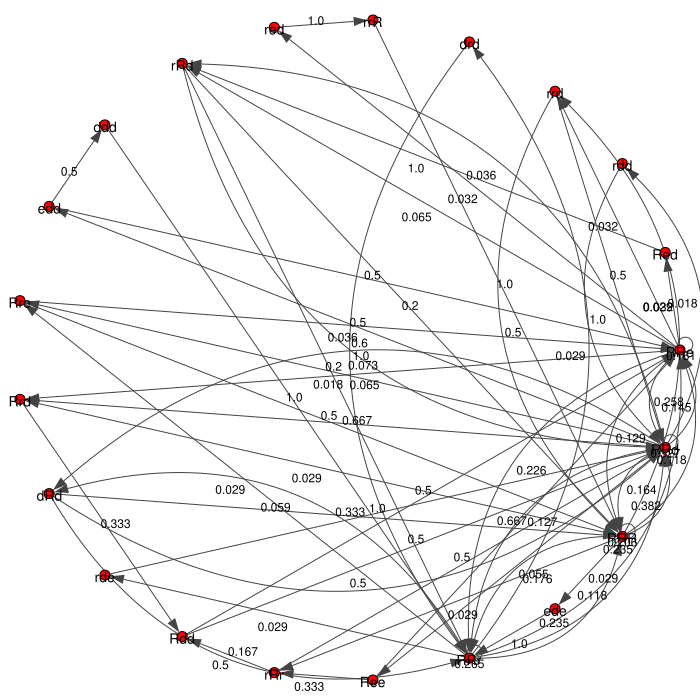

<Figure size 1000x1000 with 0 Axes>

In [443]:
# plot the graph
plt.figure(figsize=(10, 10))
ig.plot(g,
        vertex_size=10,
        vertex_label=g.vs['names'],
        edge_label=g.es['weight'],
        bbox=(700, 700),
        layout='circular',
        )

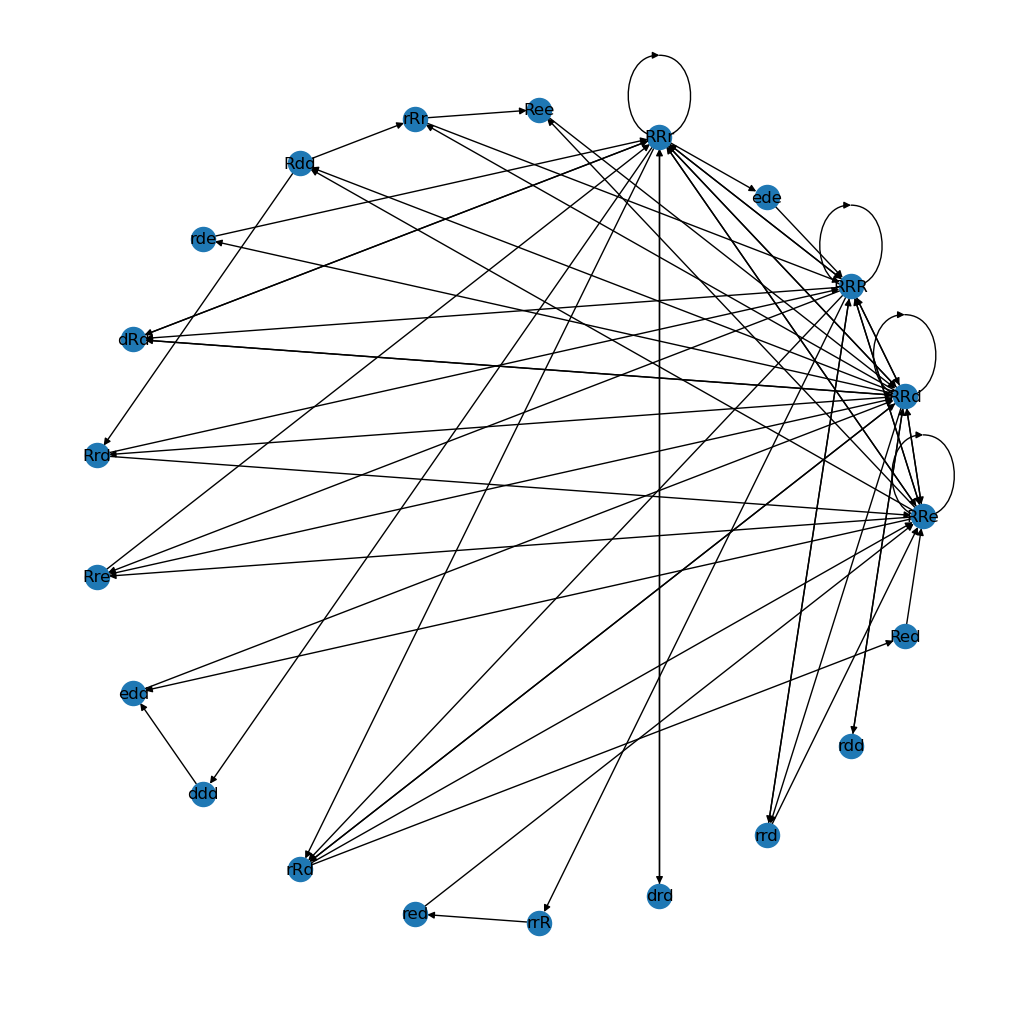

In [444]:
plt.figure(figsize =(10, 10))
nx.draw_circular(G, with_labels = True, )

#### TASK 3

In [509]:
ticker_mask = 'GAZP'
one_ticker_df = pd.DataFrame(data = tickers_df.loc[:, [f'{ticker_mask}', f'{ticker_mask}_norm_return', f'mc_{ticker_mask}']], index = tickers_df.index)

In [510]:
lag = 3
one_ticker_df[f'lag_{lag}'] = ''
for l in range(lag):
    one_ticker_df[f'lag_{lag}'] += one_ticker_df[f'mc_{ticker_mask}'].shift(-l)
    
one_ticker_df[f'next_lag_{lag}'] = one_ticker_df[f'lag_{lag}'] + one_ticker_df[f'lag_{lag}'].shift(-1)
one_ticker_df = one_ticker_df.dropna()

In [511]:
conditions = list(one_ticker_df.lag_3.unique())
condtion_literals = ['R', 'r', 'e', 'd', 'D']

In [531]:
possible_transitions = {}
for condition in conditions:
    possible_transitions[condition] = {}
    for literal in condtion_literals:
        possible_transitions[condition][condition[1:]+literal] = 0

In [519]:
# timepropagating transitions dict
time_trans_dict = {}
for condition in conditions:
    transitions_out = 0
    time_trans_dict[condition] = {}
    #print(f'condtition = {condition}')
    for allowed_condition in possible_transitions[condition]:
        #print(f'{condition} => {allowed_condition}')
        transitions_to_ac = one_ticker_df[one_ticker_df[f'next_lag_{lag}'] == condition + allowed_condition][f'next_lag_{lag}'].count()
        transitions_out += transitions_to_ac
        time_trans_dict[condition][allowed_condition] = transitions_to_ac
    #cumulative_prob = 0
    for allowed_condition in possible_transitions[condition]:
        time_trans_dict[condition][allowed_condition] = round( (time_trans_dict[condition][allowed_condition] / transitions_out), 3)
        cumulative_prob += time_trans_dict[condition][allowed_condition]
    #print(cumulative_prob)
time_trans_dict_df = pd.DataFrame(time_trans_dict)

In [657]:
adjacency_matrix = np.zeros(shape=(len(conditions), len(conditions)), dtype=float)

for i, condition1 in enumerate(conditions):
    for j, condition2 in enumerate(conditions):
        if condition2 in list(possible_transitions[condition1].keys()):
            adjacency_matrix[i, j] = time_trans_dict[condition1][condition2]
        
g = ig.Graph.Adjacency((adjacency_matrix > 0).tolist())
g.vs['names'] = [key for key in time_trans_dict.keys()]
g.es['weight'] = adjacency_matrix[adjacency_matrix.nonzero()]

#G = nx.DiGraph(time_trans_dict_df > 0)

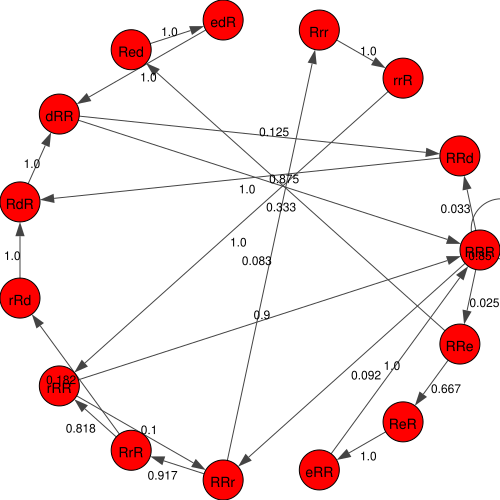

<Figure size 500x500 with 0 Axes>

In [539]:
# plot the graph
plt.figure(figsize=(5, 5))
ig.plot(g,
        vertex_size=40,
        vertex_label=g.vs['names'],
        edge_label=g.es['weight'],
        bbox=(500, 500),
        layout='circular',
        )

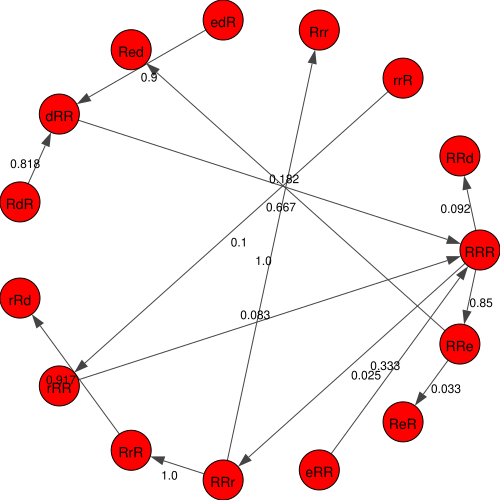

In [542]:
ig.plot(g.spanning_tree(),
        vertex_size=40,
        vertex_label=g.vs['names'],
        edge_label=g.es['weight'],
        bbox=(500, 500),
        layout='circular',
        )

#### TASK 4 

In [808]:
tickers
ticker_returns = [f'{ticker}_norm_return' for ticker in tickers]

In [809]:
# construct correlation graph
corr_matrix = tickers_df.loc[:, ticker_returns].corr()
corr_matrix.columns, corr_matrix.index = tickers, tickers

In [810]:
corr_matrix[corr_matrix > 0.4]

GAZP      SBER      LKOH      YNDX      GMKN      NVTK      ROSN
GAZP  1.000000  0.443516  0.435028  0.412464  0.585135  0.519994  0.545978
SBER  0.443516  1.000000       NaN       NaN       NaN  0.452714  0.448754
LKOH  0.435028       NaN  1.000000  0.426440  0.400124  0.503731  0.557048
YNDX  0.412464       NaN  0.426440  1.000000       NaN  0.410008  0.440083
GMKN  0.585135       NaN  0.400124       NaN  1.000000  0.451994  0.486360
NVTK  0.519994  0.452714  0.503731  0.410008  0.451994  1.000000  0.551033
ROSN  0.545978  0.448754  0.557048  0.440083  0.486360  0.551033  1.000000

In [811]:
selected_elem = corr_matrix[(corr_matrix > 0.4) & (corr_matrix < 1.)].fillna(0)
np_selected = np.array(selected_elem).round(3)

In [821]:
g = ig.Graph.Adjacency(selected_elem > 0)
g.to_undirected()
g.vs['names'] = [ticker for ticker in tickers]
g.es['weight'] = np_selected[np_selected.nonzero()]

G = nx.Graph(corr_matrix > 0.4)

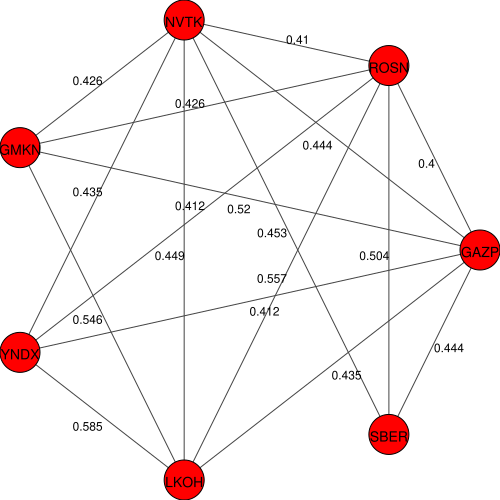

<Figure size 500x500 with 0 Axes>

In [822]:
# plot the graph
plt.figure(figsize=(5, 5))
ig.plot(g,
        vertex_size=40,
        vertex_label=g.vs['names'],
        edge_label=g.es['weight'],
        bbox=(500, 500),
        layout='circular',
        )

<Axes: >

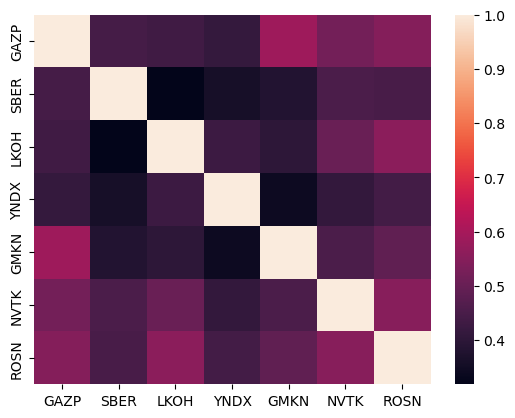

In [694]:
import seaborn as sns
sns.heatmap(corr_matrix)

#### TASK 5

In [806]:
# justigy the theorems 5,6 for visibility graph
# about average degree : k(T) = 4(1 - 1/2T)

vg = ts.NaturalVG(weighted='v_distance', min_weight = 0)
vg.build(df['norm_return'])

ivg = vg.as_igraph()
nxvg = vg.as_networkx()

#plot the graph
# plt.figure(figsize=(2, 2))
# ig.plot(ivg,
#         vertex_size=5,
#         #vertex_label=g.vs['names'],
#         #edge_label=g.es['weight'],
#         bbox=(400, 400)
#         )

df_degrees = pd.DataFrame(vg.degrees, columns=['degree'])
df_degrees.index.name = 'vx'
df_degrees.mean(), 4 * (1 - 1 / 2 / df_degrees.shape[0])

(degree    3.333333
 dtype: float64,
 3.999242424242424)

#### TASK 6

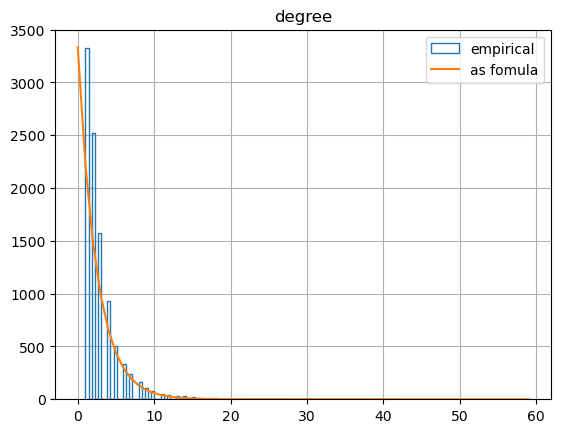

In [807]:
# for infinity sequence of iid variables
# degree distribution is ()= 1/3 * 2**(k-2)/3, k=2,3,..

N = 10_000
random_sequence = np.random.normal(loc=0, scale=1, size=(N))
vg = ts.NaturalVG(weighted='v_distance', min_weight=0)
vg.build(random_sequence)

# plt.figure(figsize=(2, 2))
# ig.plot(ivg,
#         vertex_size=5,
#         #vertex_label=g.vs['names'],
#         #edge_label=g.es['weight'],
#         bbox=(400, 400)
#         )

df_degrees = pd.DataFrame(vg.degrees, columns=['degree'])
df_degrees.index.name = 'vx'
df_degrees.hist(histtype='step', bins=100, label='empirical')
plt.plot(np.arange(60), N/3 * (2/3)**(np.arange(60)), label='as fomula')
plt.legend()

#### TASK 7

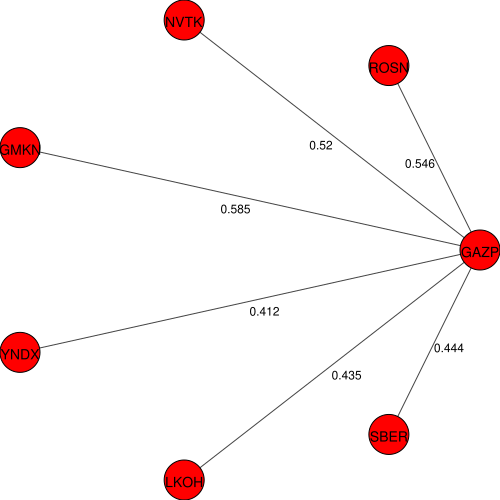

In [823]:
# build spanning tree for corr graph

g = ig.Graph.Adjacency(selected_elem > 0)
#g.to_undirected()
g.vs['names'] = [ticker for ticker in tickers]
g.es['weight'] = np_selected[np_selected.nonzero()]

corr_tree = g.spanning_tree()
corr_tree.to_undirected()
ig.plot(corr_tree,
        vertex_size=40,
        vertex_label=g.vs['names'],
        edge_label=g.es['weight'],
        bbox=(500, 500),
        layout='circular',
        )

#### TASK 8

In [826]:
norm_returns = [f'{ticker}_norm_return' for ticker in tickers]

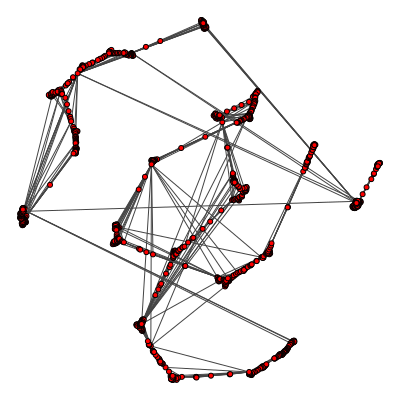

<Figure size 200x200 with 0 Axes>

In [831]:
vg = ts.NaturalVG()
vg.build(tickers_df[norm_returns].to_numpy().flatten()) # ???

ivg = vg.as_igraph()
nxvg = vg.as_networkx()

# plt.figure(figsize =(25, 25))
# nx.draw_networkx(nxvg, with_labels = True)

#plot the graph
plt.figure(figsize=(2, 2))
ig.plot(ivg,
        vertex_size=5,
        #vertex_label=g.vs['names'],
        #edge_label=g.es['weight'],
        bbox=(400, 400)
        )

#### TASK 9

In [ ]:
vg = ts.
vg.build(df['norm_return'])

ihg = vg.as_igraph()
nxhg = vg.as_networkx()

plt.figure(figsize =(25, 25))
nx.draw_networkx(nxhg, with_labels = True)

# plot the graph
plt.figure(figsize=(2, 2))
ig.plot(ihg,
        vertex_size=5,
        #vertex_label=g.vs['names'],
        #edge_label=g.es['weight'],
        bbox=(400, 400)
        )